In [41]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import utils.plots_cliffwalking as plots

from env.cliff_walking import WindyCliffWalking
from importlib import reload

# Resolvendo o ambiente Cliff Walking com QLearning tabular

O [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) é um dos mais simples ambientes de aprendizado por reforço (RL), sendo ideal para entender o funcionamento do QLearning tabular, um dos algoritmos mais fundamentais para iniciantes. A ideia do Cliff Walking é simples: o agente deve ser capaz de atravessar um tabuleiro do início ao fim tomando cuidado para não cair em um penhasco. Se o agente cair no penhasco, ele retorna para o início do tabuleiro e leva uma penalidade de recompensa.

<img src="media/cliff_walking.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Cima
* 1: Direita
* 2: Baixo
* 3: Esquerda

### Espaço de estados

O estado representa a posição do jogador no tabuleiro. Logo, o espaço de estados também é discreto e contém os inteiros do intervalo {0, 47}. O valor numérico da posição do agente no tabuleiro pode ser obtido como linha_atual * nlinhas + coluna, sendo que as linhas e colunas começam em 0.

### Recompensas

A cada movimento do agente uma penalidade de -1 é aplicada, a menos que o jogador caia do penhasco, o que resulta em uma penalidade -100.


In [76]:
cliff_walking = gym.make('CliffWalking-v0')

## Criando a tabela de QValores

A tabela de Qvalores recebe como entrada um par (estado, ação) e deve retornar o QValor desse par. Um QValor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio". Logo, devemos ter uma linha da tabela para cada um dos 48 estados, sendo que cada linha deve ter uma coluna para cada uma das 4 ações. Além disso, os QValores devem possuir um valor inicial preferencialmente diferente de zero.

<figure>
    <img src="media/qtable.png" alt="sample qtable" width="400">
    <figcaption> Exemplo de tabela de Qvalores. Fonte: <a href="https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial"> Datacamp </a> </figcaption>
</figure>

In [43]:
def new_q_table(n_states, n_actions):
    return np.full((n_states, n_actions), 0.1)

## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo QValor é o maior. No entanto, para que o QLearn convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que ele visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [44]:
def get_action(q_table, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, q_table.shape[1])
    return np.argmax(q_table[state])

## Atualização dos QValores utilizando a equação de Bellman

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para atualizar os seus QValores e, assim, aprender a tabela ótima. A atualização dos seus QValores é realizada através da equação de Bellman:

$$Q_{t+1}(s_t, a_t) = (1-\alpha) Q_t (s_t, a_t) + \alpha (R_{t+1} + \gamma \max_{a} Q_t (s_{t+1}, a))$$

In [45]:
def update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma):
    if terminated:
        q_table[next_state] = np.zeros(q_table.shape[1]) # a recompensa esperada para o estado terminal é 0

    q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]))
    return q_table

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [69]:
def train(env: gym.Env, 
          q_table,
          n_episodes=5000, # numero maximo de episodios
          epsilon=0.99, # probabilidade inicial de escolher uma ação aleatória
          epsilon_decay=0.999, # fator de decaimento da probabilidade de escolher uma ação aleatória
          alpha=0.75, # taxa de aprendizado
          gamma=0.99, # fator de desconto
          verbose=False):
     
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 1000 steps max
            action = get_action(q_table, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            q_table = update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma)
            state = next_state
            total_reward += reward

            done = terminated or truncated
            step += 1
            
        if episode % 100 == 0 and verbose:
            print(f"Episode {episode} - Total reward: {total_reward} - epsilon: {epsilon}")

    return q_table

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

In [59]:
q_table = new_q_table(n_states=48, n_actions=4)
trained_q_table = train(cliff_walking, q_table, alpha=0.75, verbose=True)

Episode 0 - Total reward: -8024 - epsilon: 0.98901
Episode 100 - Total reward: -7331 - epsilon: 0.8948484814169296
Episode 200 - Total reward: -7034 - epsilon: 0.8096518788426657
Episode 300 - Total reward: -5549 - epsilon: 0.7325666618727043
Episode 400 - Total reward: -4460 - epsilon: 0.6628205628997266
Episode 500 - Total reward: -1543 - epsilon: 0.5997148402571608
Episode 600 - Total reward: -361 - epsilon: 0.5426172779722319
Episode 700 - Total reward: -134 - epsilon: 0.4909558519974922
Episode 800 - Total reward: -250 - epsilon: 0.4442129994668515
Episode 900 - Total reward: -352 - epsilon: 0.40192043356343343
Episode 1000 - Total reward: -25 - epsilon: 0.3636544520527319
Episode 1100 - Total reward: -903 - epsilon: 0.3290316924802508
Episode 1200 - Total reward: -30 - epsilon: 0.2977052915076636
Episode 1300 - Total reward: -27 - epsilon: 0.26936140991033175
Episode 1400 - Total reward: -22 - epsilon: 0.24371608842234507
Episode 1500 - Total reward: -250 - epsilon: 0.22051240292

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [70]:
def test(env: gym.Env, 
          q_table,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_table, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return np.average(total_reward)

test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_table)

## Análise de resultados

### Visualizando a política

A célula abaixo permitirá observar a ação mais provável de ser tomada em cada uma das posições do tabuleiro.

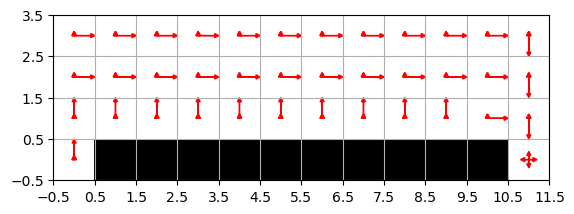

<Figure size 640x480 with 0 Axes>

In [63]:
reload(plots)
plots.plot_arrows(trained_q_table)

### Visualizando a influência da taxa de aprendizado

A célula abaixo criará um gráfico com a recompensa total média de um conjunto de agentes treinados com uma diferente taxa de aprendizado. Como você explicaria os resultados?

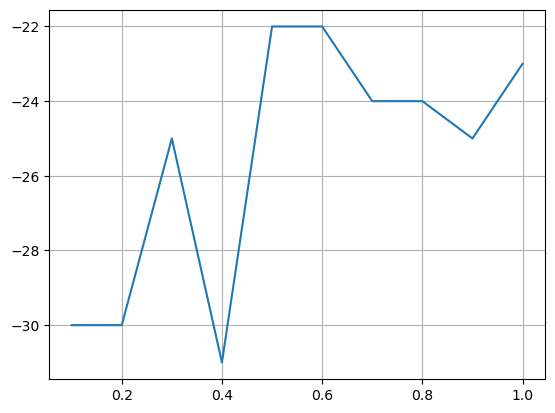

In [77]:
# retorno médio esperado em função de alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

## Exercício - ambientes não-determinísticos

Agora que já vimos que o agente aprendeu um caminho para o objetivo que minimiza a distância caminhada e não cai no penhasco, está na hora de deixar as coisas um pouco mais difíceis. Utilizaremos agora uma versão modificada do Cliff Walking que adiciona vento aleatório na direção do penhasco. Ou seja, existe uma probabilidade do agente ser deslocado uma casa para baixo de maneira involuntária.

Essa alteração será interessante para observarmos a infuência da taxa de aprendizado no treinamento de um modelo robusto a ambientes não-determinísticos.

In [ ]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(cliff_walking, windy_q_table, alpha=0.75, verbose=True)

### Resultados

In [ ]:
windy_cliff_walking.render_mode = 'human'
test(windy_cliff_walking, trained_windy_q_table)

In [ ]:
plots.plot_arrows(trained_q_table)